# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---

## Step 1: Dataset Exploration

Visualize the German Traffic Signs Dataset. This is open ended, some suggestions include: plotting traffic signs images, plotting the count of each sign, etc. Be creative!


The pickled data is a dictionary with 4 key/value pairs:

- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2). Based the original image (not the resized version).

In [1]:
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import time
from tqdm import tnrange
%matplotlib inline

In [2]:
# Load pickled data
import pickle

# TODO: fill this in based on where you saved the training and testing data
training_file = '../../sdc/traffic-signs-data/train.p'
testing_file = '../../sdc/traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

In [3]:
print('X_train.shape =', X_train.shape)
print('y_train.shape =', y_train.shape)
print('X_test.shape =', X_test.shape)
print('y_test.shape =', y_test.shape)
print('image shape = ', X_train[0].shape)
np.max(y_train)+1


X_train.shape = (39209, 32, 32, 3)
y_train.shape = (39209,)
X_test.shape = (12630, 32, 32, 3)
y_test.shape = (12630,)
image shape =  (32, 32, 3)


43

In [4]:
### To start off let's do a basic data summary.

# TODO: number of training examples
n_train = X_train.shape[0]

# TODO: number of testing examples
n_test = X_test.shape[0]

# TODO: what's the shape of an image?
image_shape = X_train[0].shape

# TODO: how many classes are in the dataset
n_classes = np.max(y_train) + 1

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


In [5]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.



# Show all classes
# num_line = 9
# num_imgs = 3
# for c in range(n_classes):
#     if c * num_imgs % num_line == 0:
#         plt.figure((c * num_imgs) // num_line, figsize=(18, 2))
#     s = X_train[y_train == c]
#     indices = np.random.randint(0, len(s), num_imgs)

#     for n, idx in enumerate(indices):
#         plot_num = (c * num_imgs) % num_line + n + 1
#         plt.subplot(1, num_line, plot_num)
#         cur_axes = plt.gca()
#         cur_axes.axes.get_xaxis().set_ticks([])
#         cur_axes.axes.get_yaxis().set_ticks([])
#         plt.imshow(s[idx])
#         plt.title('Class %d' % c)

        


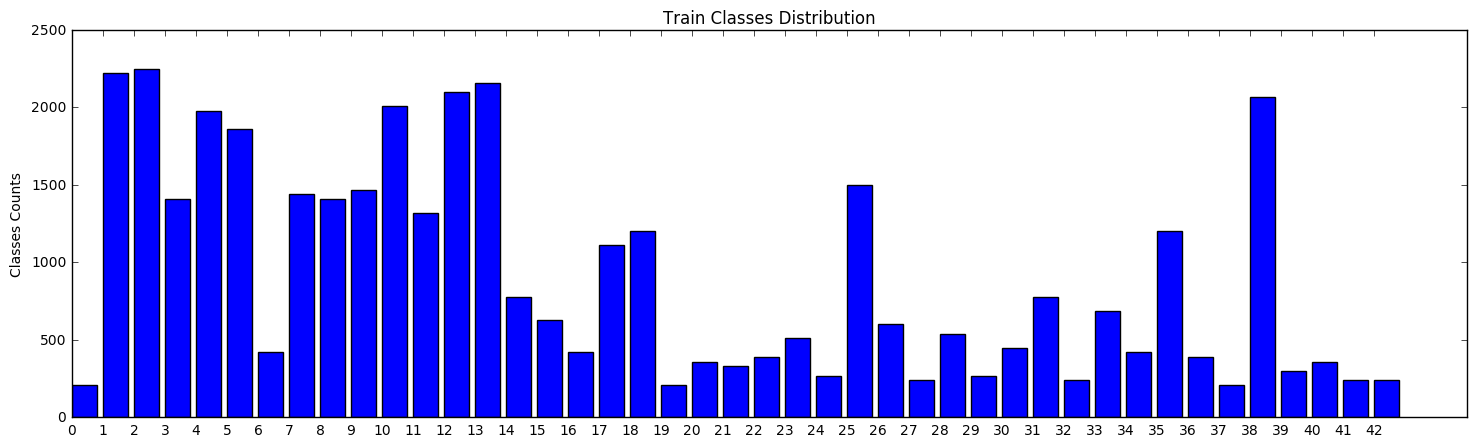

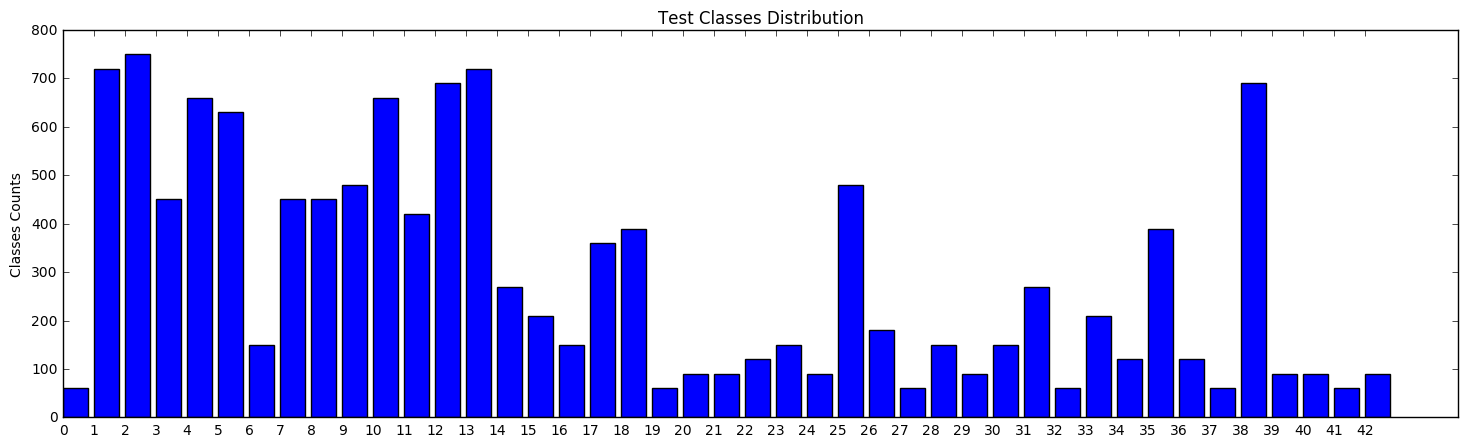

In [6]:
# Draw the classes distribution in X_train samples

def show_classes_distribution(labels, title = None):
    # Count classes samples
    uniq_labels = sorted(set(labels.tolist()))
    n_labels = len(uniq_labels)
    class_counts = np.zeros([n_labels])
    for c in uniq_labels:
        class_counts[c] = np.sum(labels == c)
    y_pos = np.arange(n_labels)
    plt.figure(figsize=(18, 5))
    plt.bar(uniq_labels, class_counts)
    plt.xticks(y_pos)
    plt.ylabel('Classes Counts')
    if title: plt.title(title)
    
show_classes_distribution(y_train, title='Train Classes Distribution')
show_classes_distribution(y_test, title='Test Classes Distribution')


----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Your model can be derived from a deep feedforward net or a deep convolutional network.
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [7]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


def data_to_grayscale(data):
    # Transform to grayscale
    shape = data.shape
    data_gray = np.zeros((shape[0], shape[1], shape[2]))
    for idx, image in enumerate(data):
        data_gray[idx] = grayscale(image)
    return data_gray
    

"""
X_train_gray = data_to_grayscale(X_train)

# Show random images from X_train_gray
n_samples = 12
n_samples_idx = np.random.randint(0, len(X_train_gray), n_samples)
gray_samples = X_train_gray[n_samples_idx]
plt.figure(figsize=(18, 5))
for n, img in enumerate(gray_samples):
    plt.subplot(1, n_samples, n + 1)
    cur_axes = plt.gca()
    cur_axes.axes.get_xaxis().set_ticks([])
    cur_axes.axes.get_yaxis().set_ticks([])
    plt.imshow(img, cmap='gray')
"""


"\nX_train_gray = data_to_grayscale(X_train)\n\n# Show random images from X_train_gray\nn_samples = 12\nn_samples_idx = np.random.randint(0, len(X_train_gray), n_samples)\ngray_samples = X_train_gray[n_samples_idx]\nplt.figure(figsize=(18, 5))\nfor n, img in enumerate(gray_samples):\n    plt.subplot(1, n_samples, n + 1)\n    cur_axes = plt.gca()\n    cur_axes.axes.get_xaxis().set_ticks([])\n    cur_axes.axes.get_yaxis().set_ticks([])\n    plt.imshow(img, cmap='gray')\n"

### Question 1 

_Describe the techniques used to preprocess the data._

**Answer:**

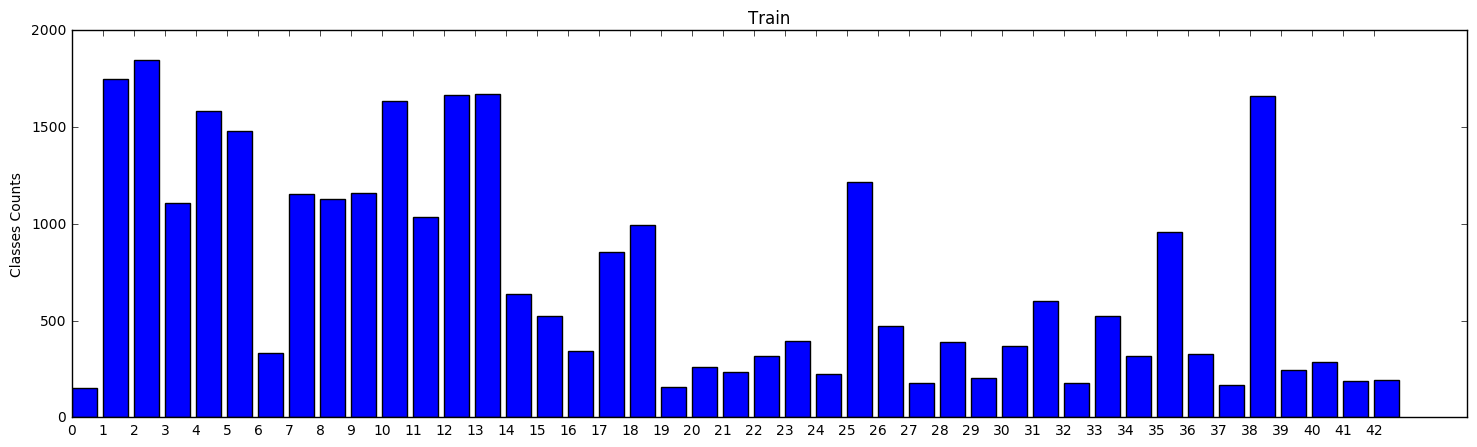

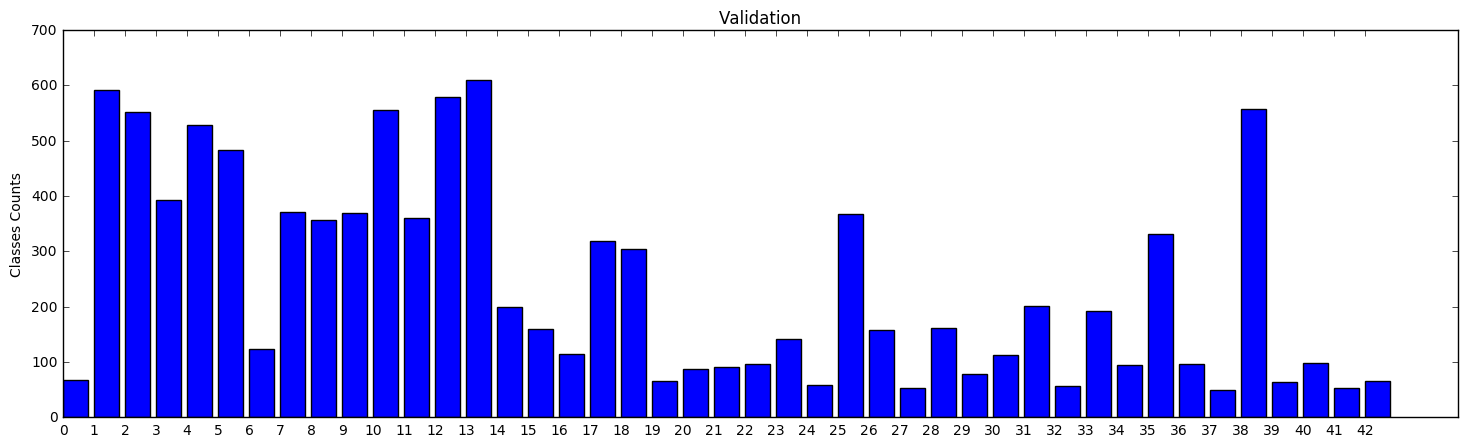

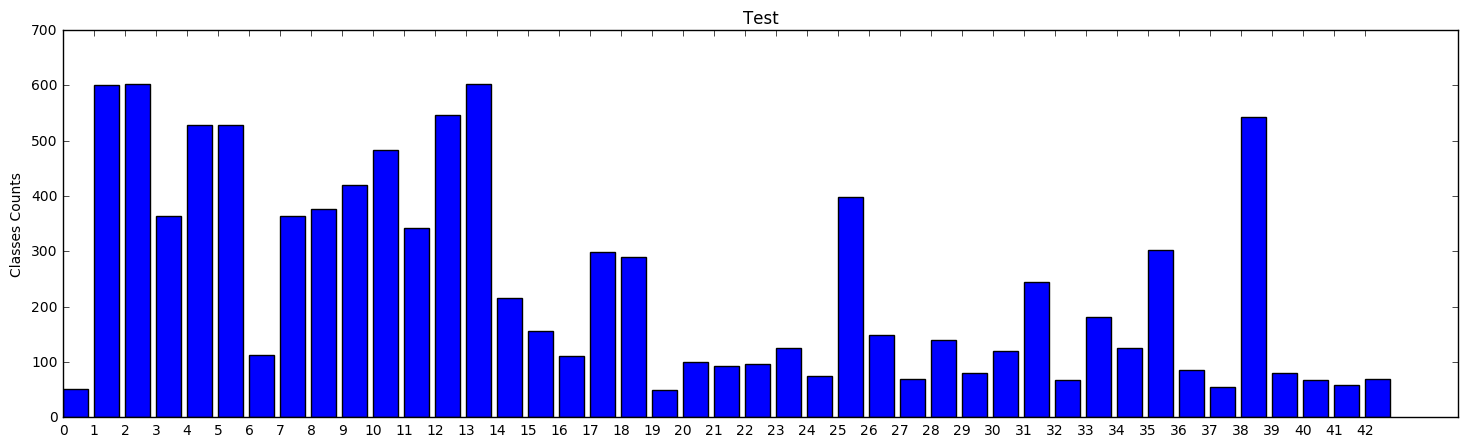

In [8]:
### Generate data additional (if you want to!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

# Generate additional data hints
# real-world variabilities such as viewpoint variations, lighting conditions
# (saturations, low-contrast), motion-blur, occlusions, sun
# glare, physical damage, colors fading, graffiti, stickers and
# an input resolution as low as 15x15


# Split Data into Train/Validation/Test

# Combine train and test into one dataset
X = np.concatenate((X_train, X_test), axis=0)
y = np.concatenate((y_train, y_test), axis=0)

# Shuffle it
r_idx = np.random.permutation(len(X))
X = X[r_idx]
y = y[r_idx]

# Train/Valid/Test distributions
p_train = 0.6
p_valid = 0.2
p_test = 0.2

# Sanity check
assert p_train + p_valid + p_test == 1.0

N = len(X)
train_idx = int(N*p_train)
valid_idx = int(N*(p_train+p_valid))
X_train = X[:train_idx]
y_train = y[:train_idx]
X_valid = X[train_idx:valid_idx]
y_valid = y[train_idx:valid_idx]
X_test = X[valid_idx:]
y_test = y[valid_idx:]
                
assert len(X_train) + len(X_valid) + len(X_test) == N
assert len(y_train) + len(y_valid) + len(y_test) == N

show_classes_distribution(y_train, 'Train')
show_classes_distribution(y_valid, 'Validation')
show_classes_distribution(y_test, 'Test')

In [9]:
# Normalize data
def normalize(data):
    pixel_depth = 255
    return (data - pixel_depth / 2) / pixel_depth

X_train_norm = normalize(X_train)
X_valid_norm = normalize(X_valid)
X_test_norm = normalize(X_test)

# print("X_train[0] =", X_valid[0])

### Question 2

_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?_

**Answer:**

In [10]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

In [11]:
# Config

class SmallConfig(object):
    """Small config. """
    # init_scale = 0.1
    image_size = 32
    num_classes = 43
    num_channels = 3
    fc1_size = 512
    learning_rate = 0.1
    num_layers = 2
    batch_size = 128 # 128
    hidden_size = 200
    max_epoch = 55 # 250 45
    keep_prob = 0.5
    lr = 0.01
    lr_decay = 0.95
    train_size = X_train.shape[0]


X_train.shape = (31103, 32, 32, 3)
y_train.shape = (31103,)
X_valid.shape = (10368, 32, 32, 3)
y_valid.shape = (10368,)
X_test.shape = (10368, 32, 32, 3)
y_test.shape = (10368,)
Initialized new model params.
Train new model ...
19/242 loss = 40.506321
39/242 loss = 35.293556
59/242 loss = 31.906298
79/242 loss = 29.198444
99/242 loss = 26.927395
119/242 loss = 24.979305
139/242 loss = 23.286144
159/242 loss = 21.806490
179/242 loss = 20.506611
199/242 loss = 19.356827
219/242 loss = 18.337303
239/242 loss = 17.427158
keep_prob = 1.0
Epoch 1/2: 
Loss: 17.341347
Validation Loss = 7.001748
LR = 0.01
19/242 loss = 6.751036
39/242 loss = 6.521821
59/242 loss = 6.298047
79/242 loss = 6.097754
99/242 loss = 5.946068
119/242 loss = 5.796957
139/242 loss = 5.654236
159/242 loss = 5.525361
179/242 loss = 5.403727
199/242 loss = 5.285117
219/242 loss = 5.173323
239/242 loss = 5.062604
keep_prob = 1.0
Epoch 2/2: 
Loss: 5.053864
Validation Loss = 3.987569
LR = 0.0095



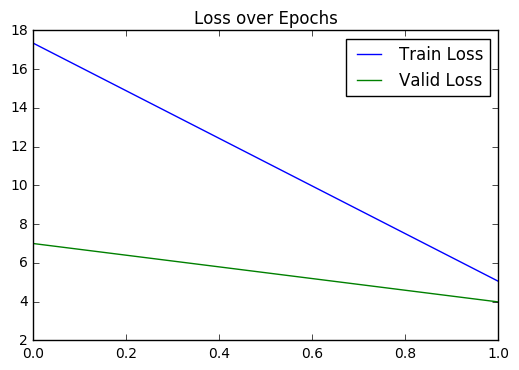

Model params saved to  model_params_201611232306.ckpt
Checking test accuracy:
size = 10368
sum_ones = 1245  of len = 10368
Test Accuracy = 0.1201


'\n    feed_dict = {\n        model.input_placeholder: X_train_gray[0:model.batch_size],\n        model.labels_placeholder: y_train[0:model.batch_size]\n    }\n    \n    _, loss, prediction = session.run([model.train_op, model.loss, model.prediction], feed_dict=feed_dict)\n    \n    print(loss)\n    print(prediction)\n'

In [12]:
# Model Define

class SignsModel(object):
    """Road Sign Classifier"""
    
    def __init__(self, config):
        self.batch_size = config.batch_size
        self.image_size = config.image_size
        self.num_classes = config.num_classes
        self.num_channels = config.num_channels
        
        self.train_size = config.train_size
        
        self.config = config
        
        self.add_placeholders()
        
        self.output_logits = self.add_model()
        
        self.loss = self.add_loss_op(self.output_logits)
        
        self.train_op = self.add_training_op(self.loss)
        
        self.prediction = self.add_prediction(self.output_logits)
    
    def add_placeholders_old(self):
        """Add Placeholders"""
        self.input_placeholder = tf.placeholder(tf.float32,
                                                shape=(self.batch_size, self.image_size, self.image_size))
        self.labels_placeholder = tf.placeholder(tf.int64, shape=(self.batch_size,))        
        
        
    def add_placeholders(self):
        """Add Placeholders"""
        self.input_placeholder = tf.placeholder(tf.float32,
                                                shape=(self.batch_size, self.image_size, self.image_size, self.num_channels),
                                                name="Inputs")
        self.labels_placeholder = tf.placeholder(tf.int64, shape=(self.batch_size,), name="Labels")
        self.dropout_placeholder = tf.placeholder(tf.float32, name="Dropout")

        
    def add_model_old(self):
        """Model Definition (it was first test model, not used now)"""
        
#         W = tf.get_variable("W", [self.image_size * self.image_size, self.num_classes], tf.float32)
#         b = tf.get_variable("b", [self.num_classes], tf.float32)
        self.params = {}

        self.params["W"] = W = tf.Variable(tf.truncated_normal([self.image_size * self.image_size, self.num_classes]), name="W")
        self.params["b"] = b = tf.Variable(tf.truncated_normal([self.num_classes]), "b")
        
        x = tf.reshape(self.input_placeholder, (self.batch_size, -1))
        output = tf.matmul(x, W) + b
        return output
    
    def add_model(self):
        """Model Definition"""

        fc1_size = self.config.fc1_size
        
        self.params = {}

        
        conv1_depth = 32
        conv2_depth = 64
        
        # Define variables
        self.params["conv1_weights"] = conv1_weights = tf.Variable(
            tf.truncated_normal([5, 5, self.num_channels, conv1_depth],
                                stddev=0.1,
                                dtype=tf.float32), name="conv1_weights")
        self.params["conv1_biases"] = conv1_biases = tf.Variable(tf.zeros([conv1_depth], dtype=tf.float32),
                                                                name="conv1_biases")
        
        self.params["conv2_weights"] = conv2_weights = tf.Variable(
            tf.truncated_normal([5, 5, conv1_depth, conv2_depth],
                                stddev=0.1,
                                dtype=tf.float32), name="conv2_weights")
        self.params["conv2_biases"] = conv2_biases = tf.Variable(tf.zeros([conv2_depth], dtype=tf.float32),
                                                                name="conv2_biases")

        
        self.params["W1"] = W1 = tf.Variable(tf.truncated_normal([self.image_size // 4 * self.image_size // 4 * conv2_depth, self.num_classes]), name="W1")
        self.params["b1"] = b1 = tf.Variable(tf.truncated_normal([self.num_classes]), "b1")
        
        # Define ops
        
        # Conv Layer 1
        conv = tf.nn.conv2d(self.input_placeholder,
                            conv1_weights,
                            strides=[1, 1, 1, 1],
                            padding='SAME')
        relu = tf.nn.relu(tf.nn.bias_add(conv, conv1_biases))
        pool = tf.nn.max_pool(relu,
                              ksize=[1, 2, 2, 1],
                              strides=[1, 2, 2, 1],
                              padding='SAME')
        
        # Conv Layer 2
        conv = tf.nn.conv2d(pool,
                            conv2_weights,
                            strides=[1, 1, 1, 1],
                            padding='SAME')
        relu = tf.nn.relu(tf.nn.bias_add(conv, conv2_biases))
        pool = tf.nn.max_pool(relu,
                              ksize=[1, 2, 2, 1],
                              strides=[1, 2, 2, 1],
                              padding='SAME')

        
        # Reshape for fully connected layers
        pshape = pool.get_shape().as_list()
        pool_line = tf.reshape(pool, [pshape[0], pshape[1] * pshape[2] * pshape[3]])
        
        # Used only during training by setting dropout param to config.keep_prob
        pool_line = tf.nn.dropout(pool_line, self.dropout_placeholder)
        
        output = tf.matmul(pool_line, W1) + b1
      
        return output

        
    def add_loss_op(self, output):
        """Loss Op"""
        loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
                output, self.labels_placeholder))

        # Regularization
        regularizers = tf.nn.l2_loss(self.params['W1']) + tf.nn.l2_loss(self.params['b1'])
        loss += 5e-4 * regularizers

        return loss
        
    def add_training_op(self, loss):
        """Add Training Op"""
        self.global_step = tf.Variable(0, dtype=tf.float32, name="global_step")
        self.learning_rate = tf.train.exponential_decay(
            self.config.lr,
            self.global_step * self.config.batch_size,
            self.train_size, # Train size
            self.config.lr_decay,
            staircase=True
        )
        optimizer = tf.train.AdamOptimizer(self.learning_rate)
        train_op = optimizer.minimize(loss, global_step=self.global_step)
        return train_op
    
    def add_prediction(self, output):
        prediction = tf.nn.softmax(output)
        return prediction
    
    def eval_predictions(self, session, data):
        batch_size = self.config.batch_size
        num_classes = self.config.num_classes
        size = data.shape[0]
        if size < batch_size:
            raise ValueError("batch size should be smaller than dataset")
        predictions = np.ndarray(shape=(size, num_classes), dtype=np.float32)
        print("size =", size)
        
        for begin in range(0, size, batch_size):
            end = begin + batch_size
            if end <= size:
                feed_dict = {
                    self.input_placeholder: data[begin:end],
                    self.dropout_placeholder: 1.0
                }
                predictions[begin:end, :] = session.run(self.prediction,
                                                        feed_dict=feed_dict)
            else:
                feed_dict = {
                    self.input_placeholder: data[-batch_size:],
                    self.dropout_placeholder: 1.0
                }
                batch_predictions = session.run(self.prediction,
                                               feed_dict=feed_dict)
                predictions[begin:] = batch_predictions[begin - size]
        return predictions
    
    def eval_accuracy(self, session, data, labels):
        predictions = self.eval_predictions(session, data)
        sum_ones = np.sum(np.argmax(predictions, axis=1) == labels)
        print("sum_ones =", sum_ones, " of len =", len(predictions))
        accuracy = sum_ones / len(predictions)
        return accuracy
    
    def run_epoch(self, session, data, labels, train_op = None, verbose = None):
        config = self.config
        batch_size = config.batch_size
        keep_prob = config.keep_prob
        num_steps = len(data) // batch_size
        
        if not train_op:
            train_op = tf.no_op()
            keep_prob = 1.0
            print("keep_prob =", keep_prob)
            steps_range = tnrange(num_steps, desc="Eval") # tqdm progress
        else:
            steps_range = tnrange(num_steps, desc="Steps") # tqdm progress
        
        total_loss = []
#         print("num_steps =", num_steps)
        for step in steps_range:
            x = data[step*batch_size:(step+1)*batch_size]
            y = labels[step*batch_size:(step+1)*batch_size]
            
#             print("x.shape =", x.shape)
#             print("y.shape =", y.shape)
            feed_dict = {
                self.input_placeholder: x,
                self.labels_placeholder: y,
                self.dropout_placeholder: keep_prob
            }
            _, loss, prediction = session.run([train_op, self.loss, self.prediction], feed_dict=feed_dict)
#             print("- conv =", conv)
#             print("- loss =", loss)
#             print("- logits =", logits)
#             print("- prediction =", prediction)
#             print("- prediction1 =", prediction[:, np.argmax(prediction, axis=1)])
#             print("- prediction max =", np.argmax(prediction, axis=1))
#             print("- y =", y)
            total_loss.append(loss)
#             print("loss =", loss)
            if verbose is not None and (step + 1) % verbose == 0:
                print("%d/%d loss = %f" % (step, num_steps, np.mean(total_loss)))
#             if step > 80: break
            
        return np.mean(total_loss)
    
    
    def train_model(self, session, train_data, train_labels, valid_data, valid_labels):
        max_epoch = self.config.max_epoch
        
        total_train_loss = []
        total_valid_loss = []
        epoch_valid_loss = 0
        for epoch in tnrange(max_epoch, desc="Epochs"):
            
            epoch_train_loss = self.run_epoch(session, train_data, train_labels, train_op = self.train_op, verbose = 20)
            total_train_loss.append(epoch_train_loss)
            
            epoch_valid_loss = self.run_epoch(session, valid_data, valid_labels)
            total_valid_loss.append(epoch_valid_loss)
            
            if epoch % 1 == 0 or epoch + 1 == max_epoch:
                print("Epoch %d/%d: " % (epoch + 1, max_epoch))
                print("Loss: %f" % epoch_train_loss)
                print("Validation Loss = %f" % (epoch_valid_loss))
                lr = session.run(self.learning_rate)
                print("LR =", lr)

                
        x_lab = np.arange(max_epoch)
        
        fig, ax = plt.subplots()
        ax.plot(x_lab, total_train_loss, '', label='Train Loss')
        ax.plot(x_lab, total_valid_loss, '', label='Valid Loss')
        ax.legend(loc='upper right')
        ax.set_title("Loss over Epochs")
        plt.show()
        
            
        return epoch_valid_loss
            
            

            
print("X_train.shape =", X_train_norm.shape)
print("y_train.shape =", y_train.shape)
print("X_valid.shape =", X_valid_norm.shape)
print("y_valid.shape =", y_valid.shape)
print("X_test.shape =", X_test_norm.shape)
print("y_test.shape =", y_test.shape)
            
        
config = SmallConfig()
model = SignsModel(config)

# To train model from scratch change this to False
restore = False
restore_file = 'model_params_201611232249.ckpt'

# Create a session
session = tf.Session()
saver = tf.train.Saver(write_version=1)

# Restore or Initialize params
if restore and restore_file:
    saver.restore(session, restore_file)
    print("Model restored from ", restore_file)
else:
    # Init new
    all_variables = tf.all_variables()
    init = tf.initialize_variables(all_variables)
    session.run(init)
    
    print("Initialized new model params.")
    print("Train new model ...")
    model.train_model(session, X_train_norm, y_train, X_valid_norm, y_valid)
    
    save_time = time.strftime("%Y%m%d%H%M")
    saved_path = saver.save(session, "model_params_%s.ckpt" % save_time)
    print("Model params saved to ", saved_path)




print("Checking test accuracy:")
accuracy = model.eval_accuracy(session, X_test_norm, y_test)
print("Test Accuracy = %.4f" % accuracy)

# print("Checking valid accuracy:")
# accuracy = model.eval_accuracy(session, X_valid_norm, y_valid)
# print("Valid accuracy = %.4f" % accuracy)



#     predictions = model.eval_predictions(session, X_test_gray)
#     print("Predictions.shape =", predictions.shape)
#     accuracy = np.sum(np.argmax(predictions, axis=1) == y_test) / len(predictions)
#     print("Accuracy = %.3f" % accuracy)

#     print("Predictions =", np.argmax(predictions, axis=1))

    
"""
    feed_dict = {
        model.input_placeholder: X_train_gray[0:model.batch_size],
        model.labels_placeholder: y_train[0:model.batch_size]
    }
    
    _, loss, prediction = session.run([model.train_op, model.loss, model.prediction], feed_dict=feed_dict)
    
    print(loss)
    print(prediction)
"""

In [13]:
# t = X_train[0:1]
# feed_dict = {
#     model.input_placeholder: t,
#     model.dropout_placeholder: 1.0
# }
# pred = session.run([model.prediction], feed_dict=feed_dict)
# print("pred =", pred)
# print("pred1 =", pred1)
# print("pred max =", np.argmax(pred1))
# print("len(X_train =", len(X_train))
# print("len(X_valid) =", len(X_valid))
# print("len(X_test) =", len(X_test))

# accuracy = model.eval_accuracy(session, X_train[0:1], y_train[0:1])
# print("Accuracy = %.3f" % accuracy)

# plt.imshow(t[0])


# Test Accuracies
print("Checking test accuracy:")
accuracy = model.eval_accuracy(session, X_test_norm, y_test)
print("Test Accuracy = %.4f" % accuracy)

print("Checking valid accuracy:")
accuracy = model.eval_accuracy(session, X_valid_norm, y_valid)
print("Valid Accuracy = %.4f" % accuracy)

print("Checking train accuracy:")
accuracy = model.eval_accuracy(session, X_train_norm, y_train)
print("Train Accuracy = %.4f" % accuracy)

# Save Params to File
# saver = tf.train.Saver(write_version=1)
# save_time = time.strftime("%Y%m%d%H%M")
# saved_path = saver.save(session, "model_params_%s.ckpt" % save_time)
# print("Model params saved to ", saved_path)



Checking test accuracy:
size = 10368
sum_ones = 1245  of len = 10368
Test Accuracy = 0.1201
Checking valid accuracy:
size = 10368
sum_ones = 1334  of len = 10368
Valid Accuracy = 0.1287
Checking train accuracy:
size = 31103
sum_ones = 3779  of len = 31103
Train Accuracy = 0.1215


In [14]:
# Model Creation
# a = [x for x in range(0, 50, 15)]
# l = np.arange(4)
# b = range(4)
# print(a)
# plt.plot(l, b, "", l*2, b)
# plt.title("Loss 1")

# plt.plot([1,2,3,4], range(4))
# plt.title("Loss 2")

# a = np.arange(9).reshape([3,3])
# l = [2,1,1]
# b = [2, 0, 0]
# print(a[:, b])

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

In [15]:
### Train your model here.
### Feel free to use as many code cells as needed.

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

### Question 5


_What approach did you take in coming up with a solution to this problem?_

**Answer:**

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [16]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._



**Answer:**

In [17]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

### Question 7

_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the dataset?_


**Answer:**

In [18]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


**Answer:**

### Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._


**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.